In [ ]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_trajectories
from mlcolvar.utils.io import create_dataset_from_files


dataset_graph = create_dataset_from_trajectories(
    trajectories=[
        'data/r.dcd',
        'data/p.dcd',
        # 'data/biased.trajectory.h5',
        'data/biased.dcd',
        #'data/biased.trajectory.h5',
        #'data/r.dcd'
    ],
    top=['data/r.pdb', 
         'data/p.pdb',
         'data/r.pdb',
         #'data/r.pdb'
         ],
    cutoff=8.0,  # Ang
    create_labels=True,
    system_selection='all and not type H',
    show_progress=False
)


datamodule_graph = DictModule(dataset_graph, lengths=[1], shuffle=False)
print(datamodule_graph)

DictModule(dataset -> DictDataset( "data_list": 1700, "z_table": [6, 9], "cutoff": 8.0, "data_type": graphs ),
		     train_loader -> DictLoader(length=1, batch_size=1700, shuffle=False))


In [28]:
import torch
from mlcolvar.utils.io import load_dataframe

df = load_dataframe('data/colvar', stride=100)
weights = torch.exp(1*torch.tensor(df['opes.bias'].values))
weights = weights / weights.sum()
weights

aux = torch.zeros(len(dataset_graph))
for i in range(len(weights)):
    aux[-(len(weights)-i)] = weights[i]
aux

for i in range(len(dataset_graph)):
    dataset_graph['data_list'][i]['weight'] = aux[i]

In [2]:
len(dataset_graph)

1700

In [29]:
from mlcolvar.cvs.committor import Committor
from mlcolvar.core.nn.graph.schnet import SchNetModel
import torch

gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset_graph.metadata['cutoff'],
                        atomic_numbers=dataset_graph.metadata['z_table'],
                        n_bases=16,
                        n_layers=2,
                        n_filters=32,
                        n_hidden_channels=32,
                    )

model = Committor(model=gnn_model,
                  mass=torch.Tensor([12, 19]),
                  alpha=1)

model

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


Committor(
  (loss_fn): CommittorLoss()
  (nn): SchNetModel(
    (_radial_embedding): RadialEmbeddingBlock(
      (bessel_fn): GAUSSIANBASIS [ 16 󰯰 | 8.000000 󰳁 ]
    )
    (W_v): Linear(in_features=2, out_features=32, bias=False)
    (layers): ModuleList(
      (0-1): 2 x InteractionBlock(
        (mlp): Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
          (1): ShiftedSoftplus()
          (2): Linear(in_features=32, out_features=32, bias=True)
        )
        (conv): CFConv()
        (act): ShiftedSoftplus()
        (lin): Linear(in_features=32, out_features=32, bias=True)
      )
    )
    (W_out): ModuleList(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): ShiftedSoftplus()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (sigmoid): Custom_Sigmoid()
)

In [34]:
from lightning import Trainer

trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='cuda',
    max_epochs=5000,
    enable_model_summary=False,
    limit_val_batches=0, 
    num_sanity_val_steps=0
)

trainer.fit(model, datamodule_graph)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


In [35]:
loader = datamodule_graph
test = next(iter(loader.train_dataloader()))['data_list']
out_graph = model(test)

In [36]:
out_graph

tensor([[1.1561e-08],
        [1.6096e-09],
        [1.0000e+00],
        ...,
        [1.0000e+00],
        [1.3562e-09],
        [1.0000e+00]], grad_fn=<MulBackward0>)

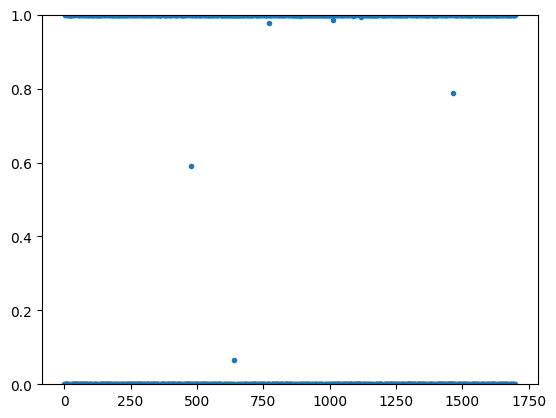

In [37]:
import matplotlib.pyplot as plt

# plt.hist(out_graph.detach().squeeze())
plt.plot(out_graph.detach().squeeze(), '.')
plt.ylim(0,1)
plt.show()